# MAGMA experimnetations

## Artificial data : Different HP + Common grid

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel, GaussianKernel
from MAGMA import MAGMA

### Data

In [2]:
N = 100
M = 20

t0 = 10
tN = 20

common_T = np.linspace(t0, tN, N)
print(common_T.shape)

(100,)


In [3]:
a = np.random.uniform(-2, 2)
b = np.random.uniform(0, 10)

m0 = a * common_T + b
m0_function = lambda t : a * t + b
print(m0.shape)

(100,)


In [4]:
theta0 = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
print(theta0)

[33.38193078  3.72509247]


In [5]:
K_theta0 = ExponentiatedQuadraticKernel.compute_all(theta0, common_T)
print(K_theta0.shape)

(100, 100)


In [6]:
mu0 = np.random.multivariate_normal(m0, K_theta0)
print(mu0.shape)

(100,)


In [7]:
Theta = np.array([np.random.uniform(1, np.exp(5), size=M), np.random.uniform(1, np.exp(2), size=M)]).T
Sigma = np.random.uniform(0, 1, size=M)

print(Theta)
print(Sigma)

[[141.92046035   7.28130074]
 [ 11.88125331   6.89861917]
 [148.17147184   4.77082027]
 [116.0476974    6.9216968 ]
 [ 26.62948383   5.48814044]
 [ 40.57309878   4.4963346 ]
 [ 51.51683114   1.06893056]
 [ 21.81633978   6.86938616]
 [ 98.50540419   5.65621539]
 [116.37505147   1.46800989]
 [ 94.04364809   1.94306101]
 [ 93.52176494   1.15612466]
 [134.36107559   3.12695382]
 [ 47.08264129   6.9030863 ]
 [ 82.90813401   1.30255769]
 [  6.96087095   2.5097014 ]
 [ 77.06408241   4.22601669]
 [ 17.5261216    5.10078969]
 [ 60.04570593   2.61583123]
 [ 47.8440612    1.3705856 ]]
[0.84023849 0.43163739 0.73208081 0.09295442 0.95705342 0.29356931
 0.45419483 0.82315396 0.07434356 0.55041873 0.93566531 0.76845308
 0.52243471 0.87864865 0.43004118 0.01358131 0.35836584 0.74598478
 0.91866707 0.37454906]


In [8]:
Y = np.zeros((M, N))
for i in range(M):
    C_Theta = ExponentiatedQuadraticKernel.compute_all(Theta[i], common_T)
    Psi_Theta_Sigma = C_Theta + Sigma[i] * np.identity(N)
    Yi = np.random.multivariate_normal(mu0, Psi_Theta_Sigma)
    Y[i] = Yi
print(Y.shape)

(20, 100)


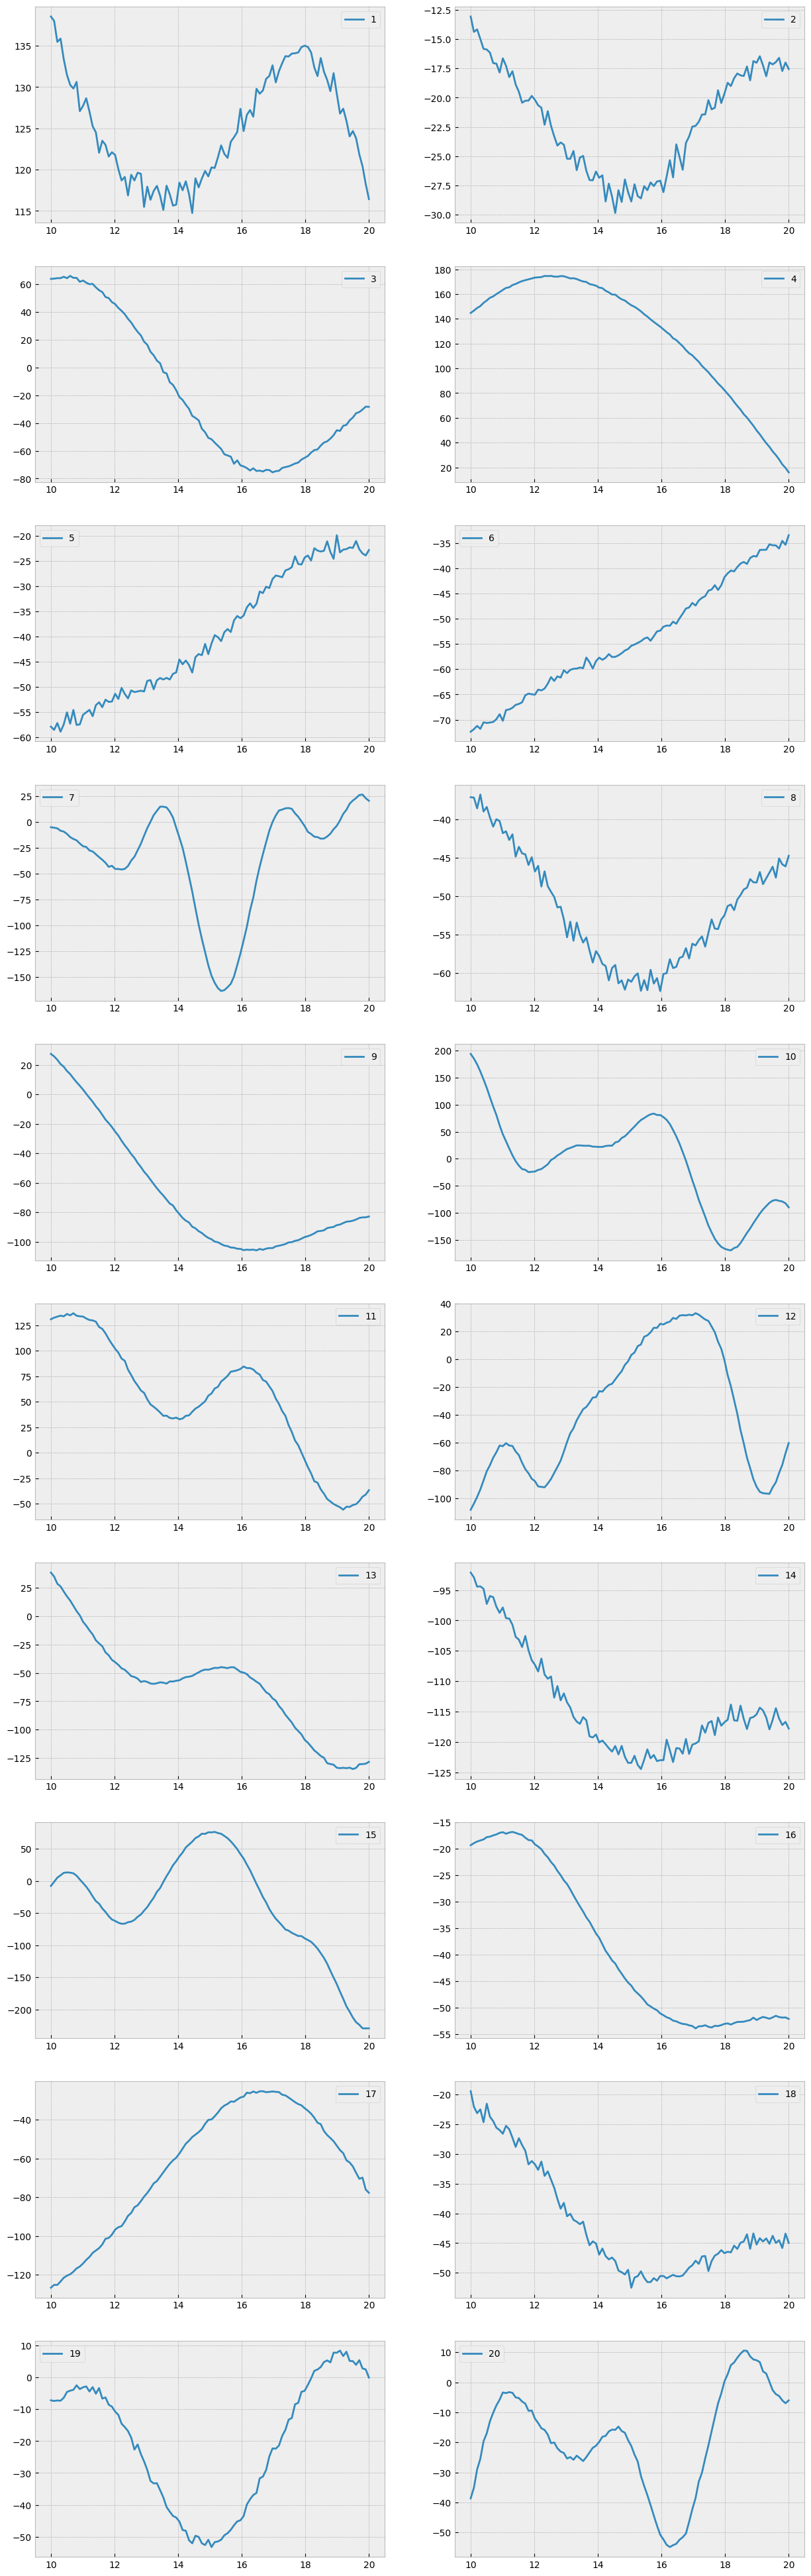

In [9]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(common_T, Y[i - 1], label=f"{i}")
    plt.legend()
plt.show()

### Model

#### Training

In [10]:
model = MAGMA(
    T=None,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(len(m0)),
    m0_function=m0_function,
    theta0=np.array([np.random.uniform(0.99,1.01), np.random.uniform(0.99,1.01)]),
    Theta=np.array([np.random.uniform(0.99,1.01, size=M), np.random.uniform(0.99,1.01, size=M)]).T,
    Sigma=np.random.uniform(0.49, 0.51, size=M),
    common_hp_flag=False,
    common_grid_flag=True,
    save_history_flag=True,
    scipy_optimize_display=True,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [11]:
model.fit(max_iterations=1, eps=1e-2)

MAGMA Training:   0%|          | 0/1 [00:00<?, ?it/s]

theta0
Theta & Sigma 0
Theta & Sigma 1
Theta & Sigma 2
Theta & Sigma 3
Theta & Sigma 4
Theta & Sigma 5
Theta & Sigma 6
Theta & Sigma 7
Theta & Sigma 8
Theta & Sigma 9
Theta & Sigma 10
Theta & Sigma 11
Theta & Sigma 12
Theta & Sigma 13
Theta & Sigma 14
Theta & Sigma 15
Theta & Sigma 16
Theta & Sigma 17
Theta & Sigma 18
Theta & Sigma 19


MAGMA Training: 100%|██████████| 1/1 [00:22<00:00, 22.63s/it]


In [12]:
model.scipy_optimize_display = False
model.fit(max_iterations=49, eps=1e-2)

MAGMA Training: 100%|██████████| 49/49 [03:26<00:00,  4.21s/it]


In [13]:
history = model.history
len(history)

51

In [14]:
LL_theta0 = []
LL_Theta_Sigma = []

for epoch_history in history[1:]:
    LL_theta0.append(epoch_history["LL_theta0"])
    LL_Theta_Sigma.append(epoch_history["LL_Theta_Sigma"])

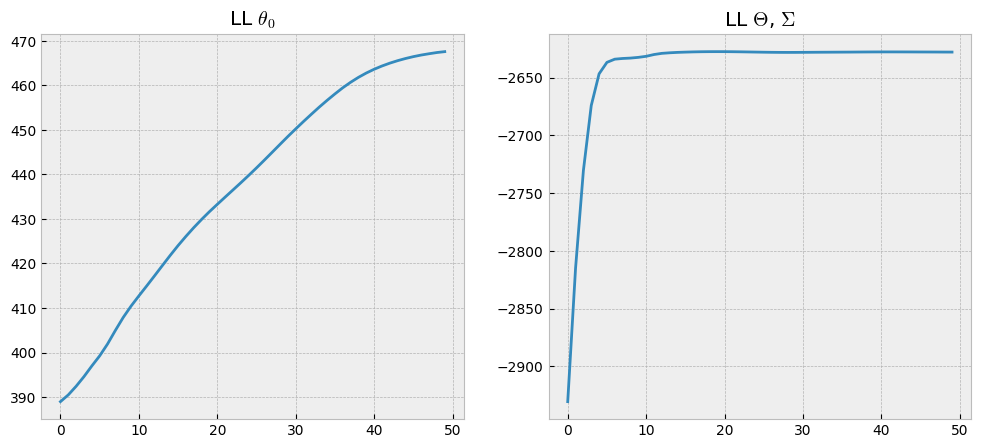

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(LL_theta0)
plt.title("LL $\\theta_0$")
plt.subplot(1, 2, 2)
plt.plot(LL_Theta_Sigma)
plt.title("LL $\Theta$, $\Sigma$")
plt.show()

In [16]:
Sigma_estim = []
for epoch_history in history:
    Sigma_estim.append(epoch_history["Sigma"])
Sigma_estim = np.array(Sigma_estim)
print(model.Sigma)
print(Sigma)

[ 1.0316064   0.6499711   0.82806212  0.29995627  0.91888454  0.49021353
  0.72335884  0.83183654  0.28083501  0.80178552  0.97126093  0.75084167
  0.65893923  0.99813209  0.67018214 -0.12864486  0.58767865  0.83115237
  0.93572635  0.58259339]
[0.84023849 0.43163739 0.73208081 0.09295442 0.95705342 0.29356931
 0.45419483 0.82315396 0.07434356 0.55041873 0.93566531 0.76845308
 0.52243471 0.87864865 0.43004118 0.01358131 0.35836584 0.74598478
 0.91866707 0.37454906]


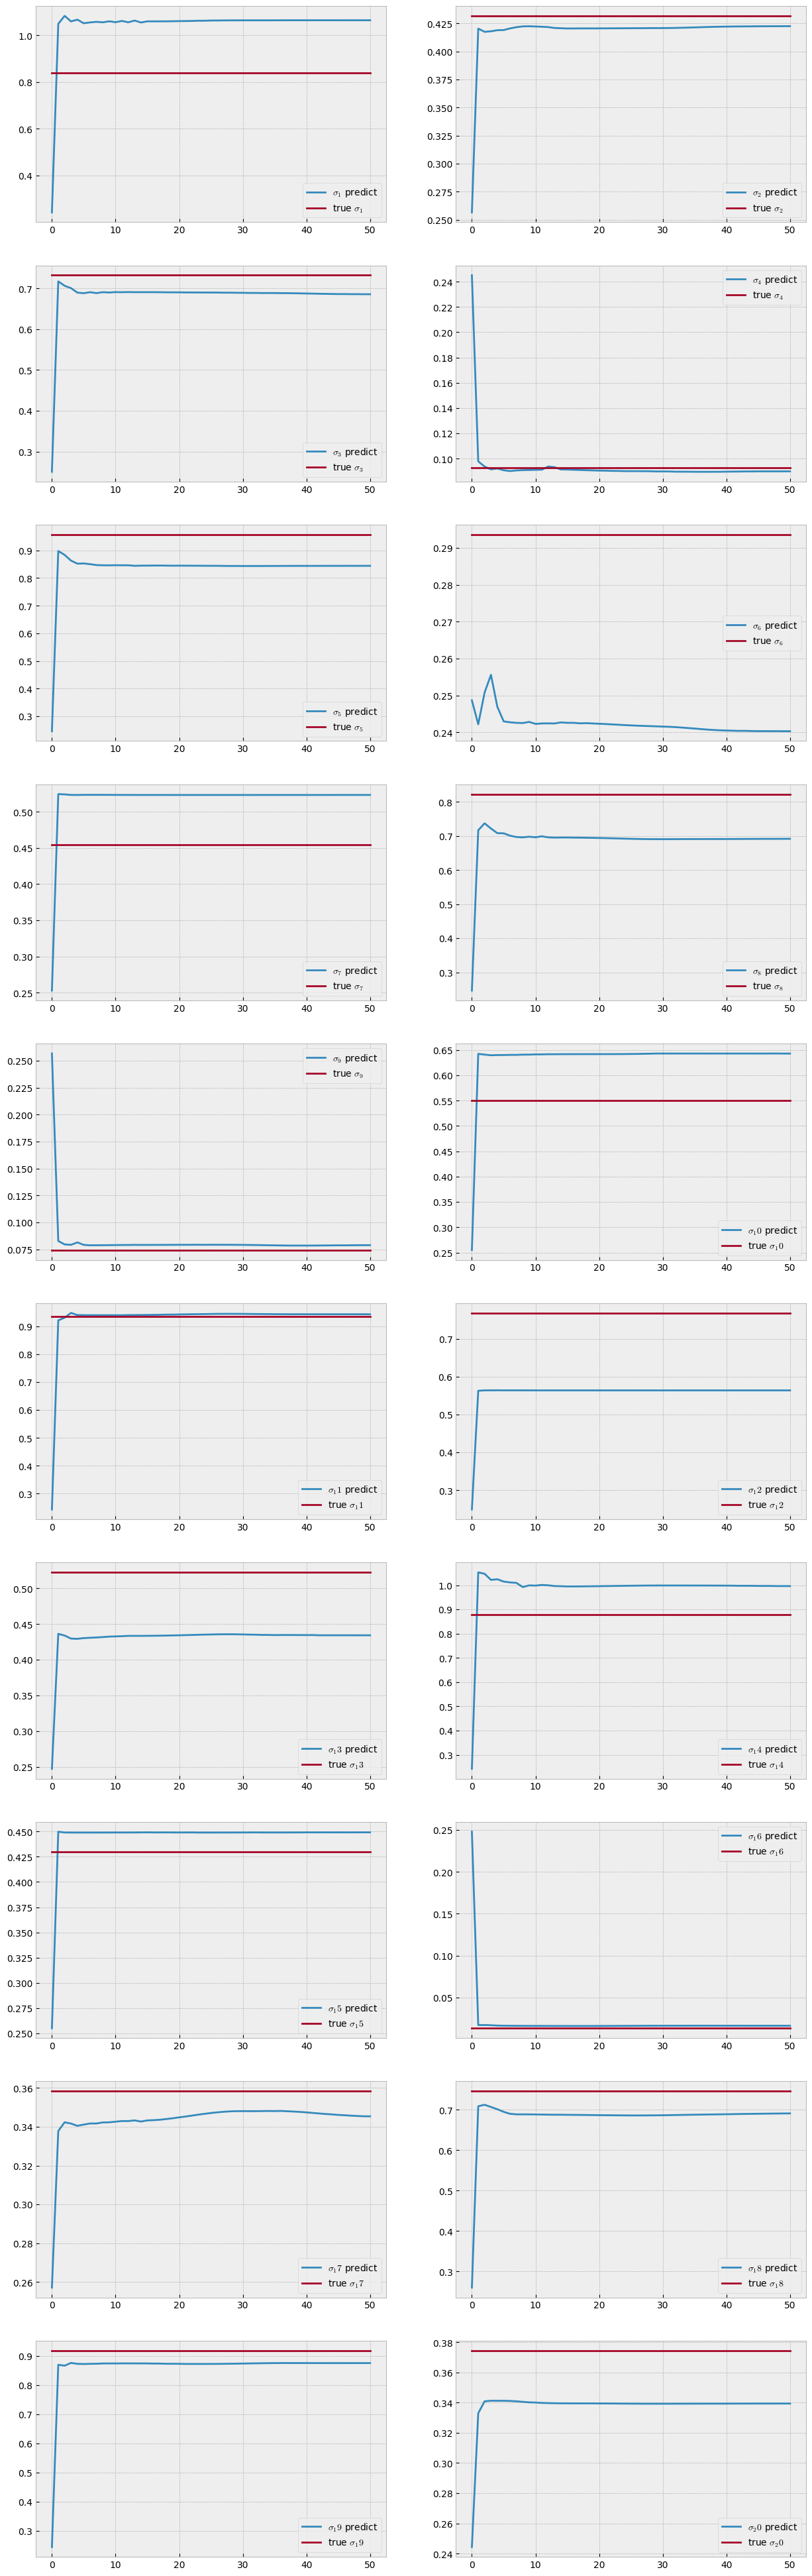

In [17]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(Sigma_estim[:, i - 1]**2, label=f"$\sigma_{i}$ predict")
    plt.plot(Sigma[i-1]*np.ones(len(Sigma_estim[:, i - 1])),label=f"true $\sigma_{i}$")
    plt.legend()
plt.show()

In [18]:
m0_estim_norms = []
for epoch_history in history[1:]:
    m0_estim_norms.append(np.linalg.norm(epoch_history["m0"]))

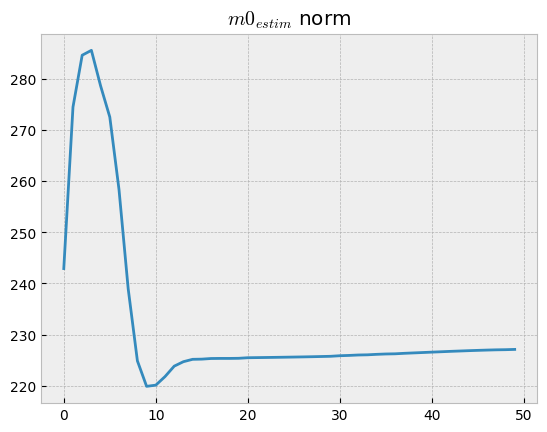

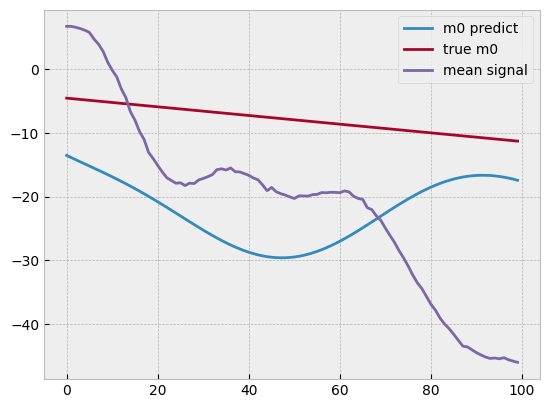

In [19]:
plt.plot(m0_estim_norms)
plt.title("$m0_{estim}$ norm")
plt.show()
plt.plot(history[-1]["m0"],label="m0 predict")
plt.plot(m0,label = "true m0")
plt.plot(Y.mean(axis=0),label = "mean signal")
plt.legend()
plt.show()

In [20]:
theta0_estim = []
for epoch_history in history:
    theta0_estim.append(epoch_history["theta0"])
theta0_estim = np.array(theta0_estim)
print(model.theta0)
print(theta0)

[18.48792751  3.42238173]
[33.38193078  3.72509247]


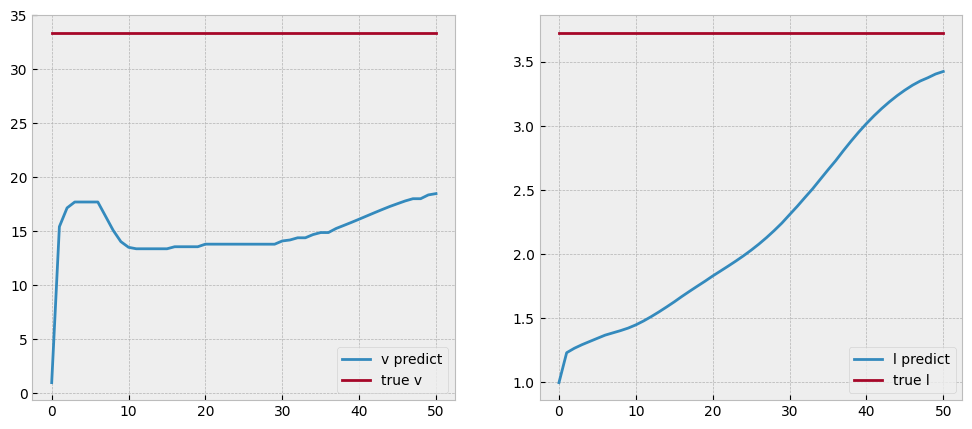

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta0_estim[:, 0], label="v predict")
plt.plot(theta0[0]*np.ones(len(theta0_estim[:, 0])), label="true v")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(theta0_estim[:, 1], label="l predict")
plt.plot(theta0[1]*np.ones(len(theta0_estim[:, 0])), label="true l")
plt.legend()
plt.show()

In [22]:
Theta_estim = []
for epoch_history in history:
    Theta_estim.append(epoch_history["Theta"])
Theta_estim = np.array(Theta_estim)
print(Theta.shape)
print(model.Theta)
print(Theta)

(20, 2)
[[121.5823916    7.5521049 ]
 [  1.32857648   2.2343117 ]
 [ 61.87782201   4.08102549]
 [128.06104094   7.31679215]
 [ 28.80407889   6.16024215]
 [ 31.03864681   4.35283344]
 [ 63.79239913   1.07954797]
 [ 23.16079454   6.52610449]
 [ 56.28308728   5.06763265]
 [164.73792465   1.53985659]
 [105.05540583   2.10375912]
 [ 58.45310413   1.14125339]
 [ 76.00482206   2.85505676]
 [ 76.58899776  22.50508426]
 [101.42964536   1.33761146]
 [ 20.60237154   3.06535426]
 [ 91.00254042   4.74317244]
 [ 17.01723822   6.09461433]
 [ 25.37505729   2.49628938]
 [ 30.18683222   1.24556406]]
[[141.92046035   7.28130074]
 [ 11.88125331   6.89861917]
 [148.17147184   4.77082027]
 [116.0476974    6.9216968 ]
 [ 26.62948383   5.48814044]
 [ 40.57309878   4.4963346 ]
 [ 51.51683114   1.06893056]
 [ 21.81633978   6.86938616]
 [ 98.50540419   5.65621539]
 [116.37505147   1.46800989]
 [ 94.04364809   1.94306101]
 [ 93.52176494   1.15612466]
 [134.36107559   3.12695382]
 [ 47.08264129   6.9030863 ]
 [ 82

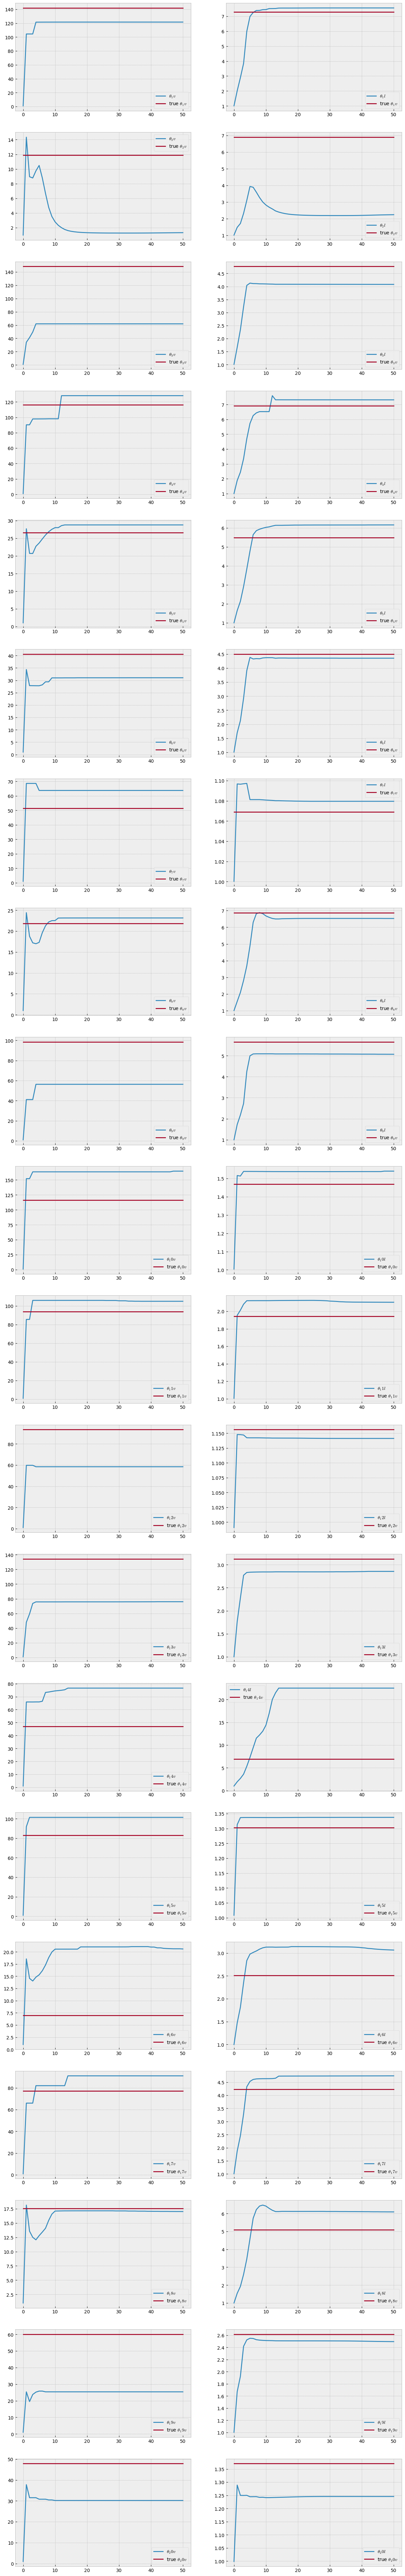

In [23]:
plt.figure(figsize=(15, M * 5))
cpt = 0
for i in range(1, M + 1):
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta_estim[:, i - 1, 0], label=f"$\\theta_{i} v$")
    plt.plot(Theta[i-1,0]*np.ones(len(theta0_estim[:, 0])), label=f"true $\\theta_{i} v$")
    plt.legend()
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta_estim[:, i - 1, 1], label=f"$\\theta_{i} l$")
    plt.plot(Theta[i-1,1]*np.ones(len(theta0_estim[:, 0])), label=f"true $\\theta_{i} v$")
    plt.legend()
plt.show()

#### Prediction

#### Type II

In [24]:
theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]).T
sigma = np.random.uniform(0, 1)
tObs = 0
T_p_obs = np.linspace(tObs, t0-1e-3, 2*N)
m_p_obs = m0_function(T_p_obs)
Cov_p_obs = ExponentiatedQuadraticKernel.compute_all(theta, T_p_obs) + sigma * np.identity(2 * N)
Y_p_obs = np.random.multivariate_normal(m_p_obs, Cov_p_obs)
T_obs = T_p_obs[:N]
T_p = T_p_obs[N:]
Y_obs = Y_p_obs[:N]
Y_p = Y_p_obs[N:]
m_P = m_p_obs[N:]

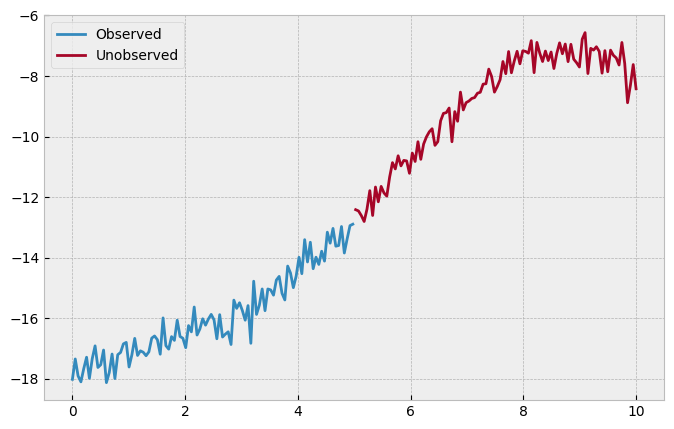

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(T_obs, Y_obs, label="Observed")
plt.plot(T_p, Y_p, label="Unobserved")
plt.legend()
plt.show()

In [26]:
m_P_predict, Cov_P_predict = model.predict(T_p, T_p, Y_p)

In [27]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

2.1122984140780154

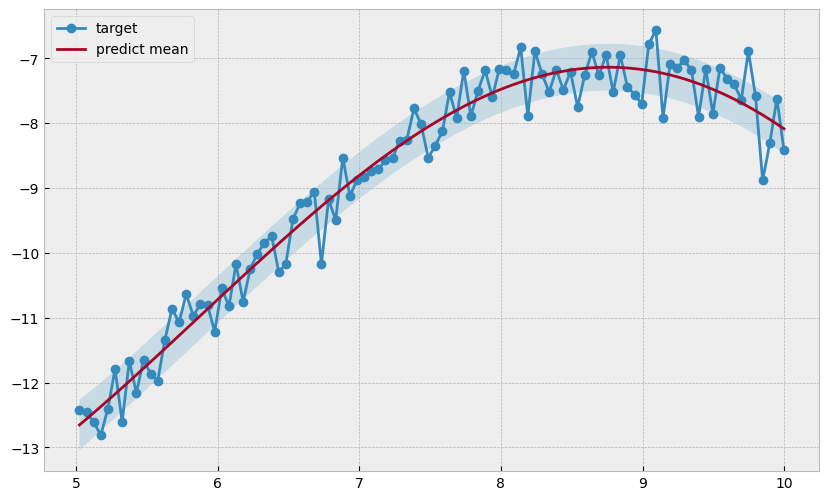

In [28]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()

In [29]:
m_P_predict, Cov_P_predict = model.predict(T_p, T_obs, Y_obs)

In [30]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

5.262031095383734

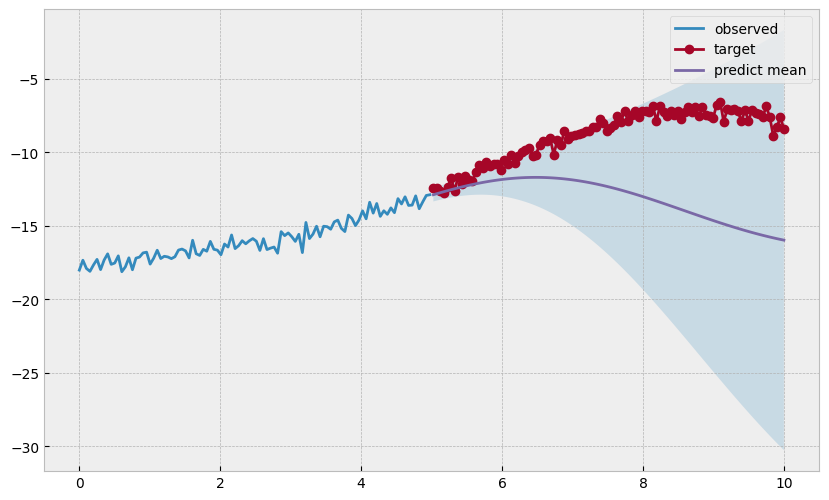

In [31]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_obs, Y_obs, label="observed")
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()

#### Type I

In [32]:
theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]).T
sigma = np.random.uniform(0, 1)
m_p_obs = m0_function(T_p_obs)
T_p_obs = np.concatenate([common_T, np.linspace(tN+1e-3, tN + 10, N)])
Cov_p_obs = ExponentiatedQuadraticKernel.compute_all(theta, T_p_obs) + sigma * np.identity(2 * N)
Y_p_obs = np.random.multivariate_normal(m_p_obs, Cov_p_obs)
T_obs = T_p_obs[:N]
T_p = T_p_obs[N:]
Y_obs = Y_p_obs[:N]
Y_p = Y_p_obs[N:]
m_P = m_p_obs[N:]

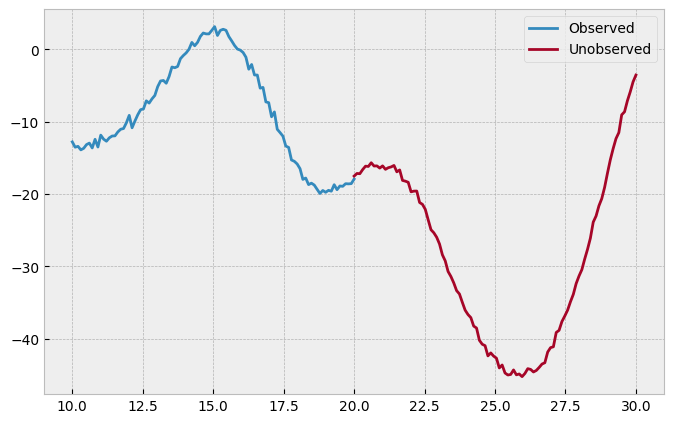

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(common_T, Y_obs, label="Observed")
plt.plot(T_p, Y_p, label="Unobserved")
plt.legend()
plt.show()

In [34]:
m_P_predict, Cov_P_predict = model.predict(T_p, common_T, Y_obs)

In [35]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

18.804323873054162

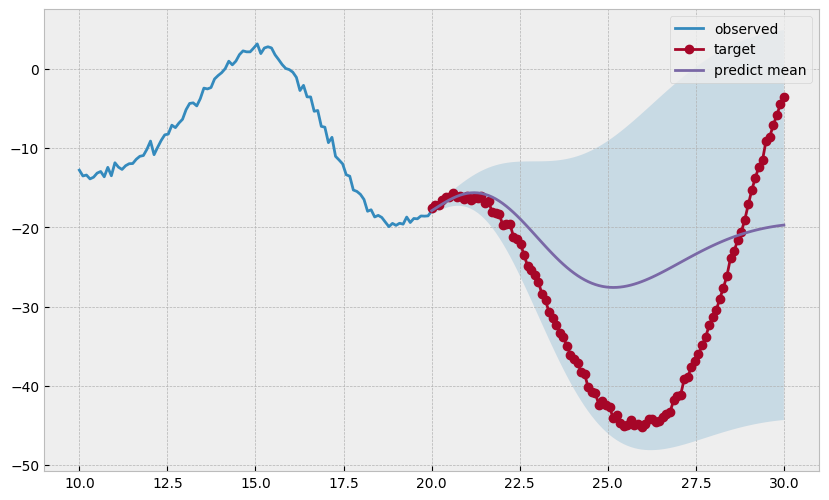

In [36]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_obs, Y_obs, label="observed")
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()